# Autoregressors with Decision Trees

...

**Packages**

In [13]:
# !pip install xgboost

In [14]:
import numpy as np
import pandas as pd
import datetime

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams 
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster

from sklearn.metrics import mean_squared_error

import warnings
# warnings.filterwarnings('ignore')

import time

import os
from pathlib import Path
project_path = Path(os.getcwd()).parent
import pickle
import joblib  

In [15]:
sns.set_style("whitegrid")

# Set Default Fonts
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Arial", "Tahoma"]

# Set Default font sizes
small_size = 12
medium_size = 14
large_size = 16

# # Change the font size for individual elements
matplotlib.rc("font", size=small_size)  # controls default text sizes
matplotlib.rc("axes", titlesize=small_size)  # fontsize of the axes title
matplotlib.rc("axes", labelsize=medium_size)  # fontsize of the x and y labels
matplotlib.rc("xtick", labelsize=small_size)  # fontsize of the tick labels
matplotlib.rc("ytick", labelsize=small_size)  # fontsize of the tick labels
matplotlib.rc("legend", fontsize=small_size)  # legend fontsize
matplotlib.rc("axes", titlesize=large_size)  # title fontsize

In [16]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

**Load data**

In [17]:
train = pd.read_parquet('../data/03_train-test/train_data.parquet')
test = pd.read_parquet('../data/03_train-test/test_data.parquet')

In [18]:
train2 = pd.read_parquet('../data/03_train-test/summed_data_train.parquet')
test2 = pd.read_parquet('../data/03_train-test/summed_data_test.parquet')

**Preparation of the data**

In [19]:
# set the index
train = train.set_index(['ds'])
test = test.set_index(['ds'])

# set the frequency
train = train.asfreq(freq='30min', fill_value=np.nan)
test = test.asfreq(freq='30min', fill_value=np.nan)

# fill nan-values
train = train.fillna(method='backfill')
test = test.fillna(method='backfill')

# conver to a Series object
train = train.squeeze()
test = test.squeeze()

In [20]:
# set the frequency
train2 = train2.asfreq(freq='D', fill_value=np.nan)
test2 = test2.asfreq(freq='D', fill_value=np.nan)

# fill nan-values
train2 = train2.fillna(method='backfill')
test2 = test2.fillna(method='backfill')

# conver to a Series object
train2 = train2.squeeze()
test2 = test2.squeeze()

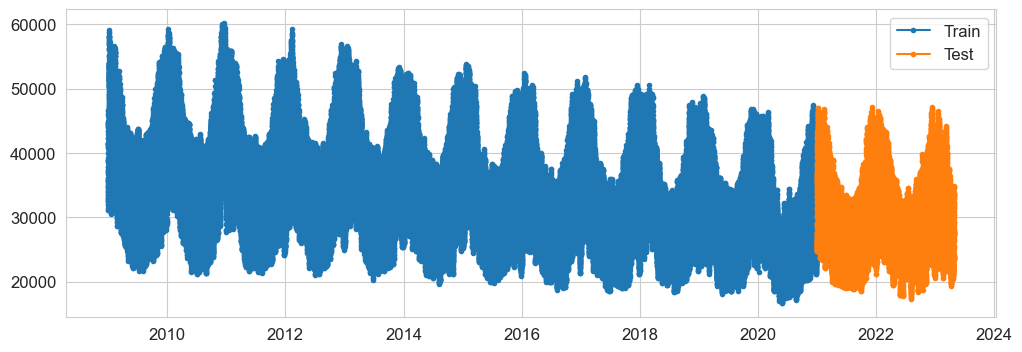

In [21]:
fig= plt.figure(figsize=(12,4))
plt.plot(train, marker='.', label='Train')
plt.plot(test, marker='.', label='Test')
plt.legend()

## Recursive multi-step forecasting 

...

In [22]:
steps = len(test)

### RandomForest

...

#### Model 1: Forecasting with the previous day

In [23]:
t1 = time.perf_counter()
RF1 = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123, n_estimators=10),
                lags = 48)

RF1.fit(y=train) # fit the model
t2 = time.perf_counter()
RF_time1 = t2-t1

In [24]:
%%time
RF_pred1 = RF1.predict(steps=steps) # predict
RF_pred1.head(5)

Wall time: 31.8 s


2021-01-01 00:00:00    29123.8
2021-01-01 00:30:00    28987.7
2021-01-01 01:00:00    28674.3
2021-01-01 01:30:00    28224.2
2021-01-01 02:00:00    27958.2
Freq: 30T, Name: pred, dtype: float64

Text(0.5, 0, '')

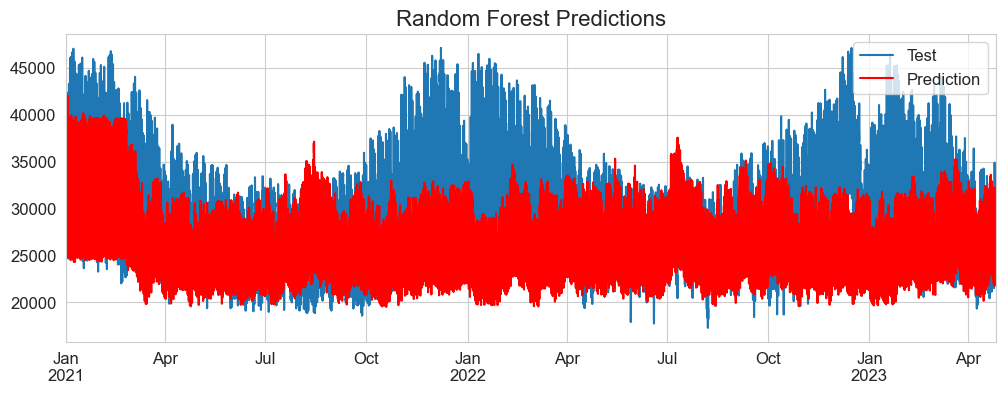

In [25]:
fig, ax = plt.subplots(figsize=(12, 4))
test.plot(ax=ax, label='Test')
RF_pred1.plot(ax=ax, label='Prediction', color='r')
ax.legend()
ax.set_title('Random Forest Predictions')
ax.set_xlabel('')

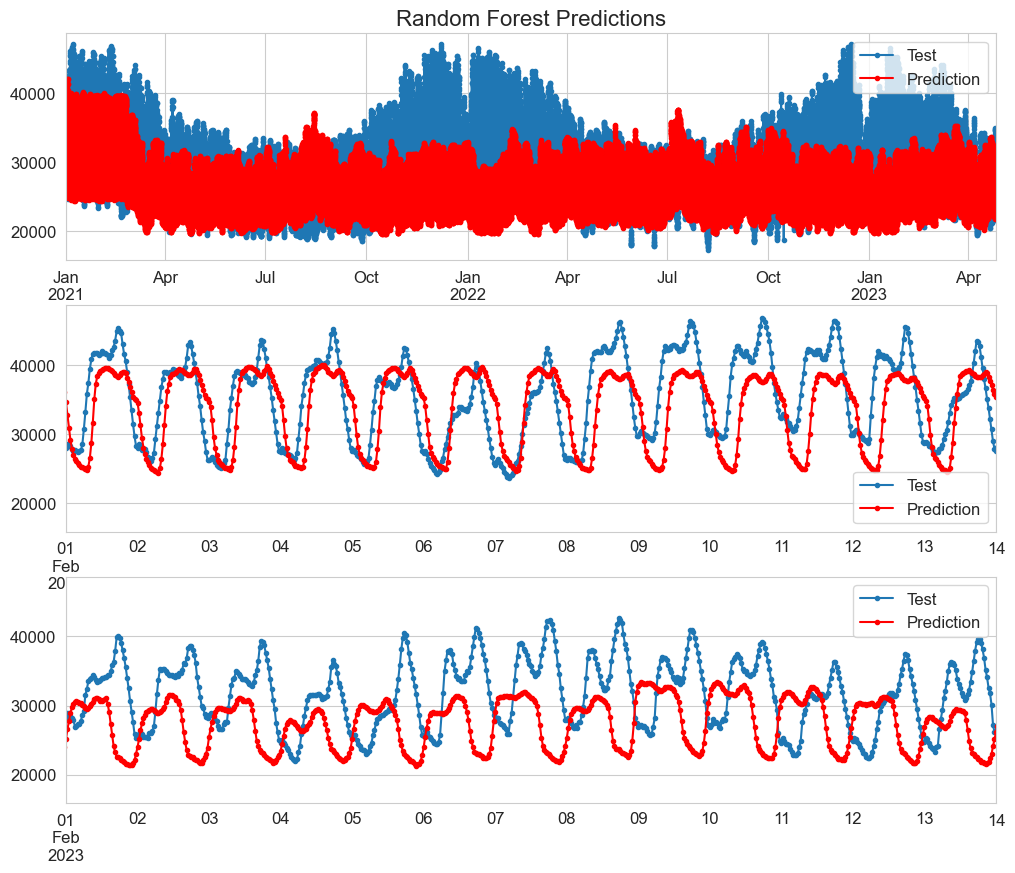

In [26]:
fig, (ax, bx, cx) = plt.subplots(3,1,figsize=(12, 10))

test.plot(ax=ax, marker='.', label='Test')
RF_pred1.plot(ax=ax, marker='.', label='Prediction', color='r')
ax.legend()
ax.set_title('Random Forest Predictions')
ax.set_xlabel('')

test.plot(ax=bx, marker='.', label='Test')
RF_pred1.plot(ax=bx, marker='.', label='Prediction', color='r')
bx.legend()
bx.set_xlabel('')
bx.set_xbound(lower=datetime.date(2021,2,1), upper=datetime.date(2021,2,14))

test.plot(ax=cx, marker='.', label='Test')
RF_pred1.plot(ax=cx, marker='.', label='Prediction', color='r')
cx.legend()
cx.set_xlabel('')
cx.set_xbound(lower=datetime.date(2023,2,1), upper=datetime.date(2023,2,14))

**Error**

In [27]:
RF_mse1  = mean_squared_error(y_true = test,y_pred = RF_pred1)
RF_mape1 = mean_absolute_percentage_error(y_true=test, y_pred=RF_pred1)

print('MAPE:', RF_mape1)
print('MSE: ', RF_mse1)

MAPE: 18.820462276578205
MSE:  50238635.61542955


#### Model 2: Forecasting with the previous week

In [28]:
t1 = time.perf_counter()
RF2 = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123, n_estimators=10),
                lags = 48*7)

RF2.fit(y=train) # fit the model
t2 = time.perf_counter()
RF_time2 = t2-t1

In [29]:
%%time
RF_pred2 = RF2.predict(steps=steps) # predict

Wall time: 32.2 s


Text(0.5, 0, '')

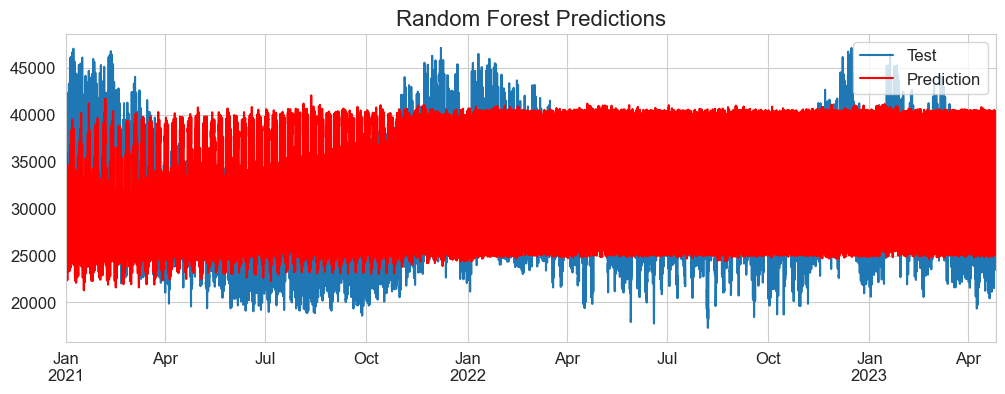

In [30]:
fig, ax = plt.subplots(figsize=(12, 4))
test.plot(ax=ax, label='Test')
RF_pred2.plot(ax=ax, label='Prediction', color='r')
ax.legend()
ax.set_title('Random Forest Predictions')
ax.set_xlabel('')

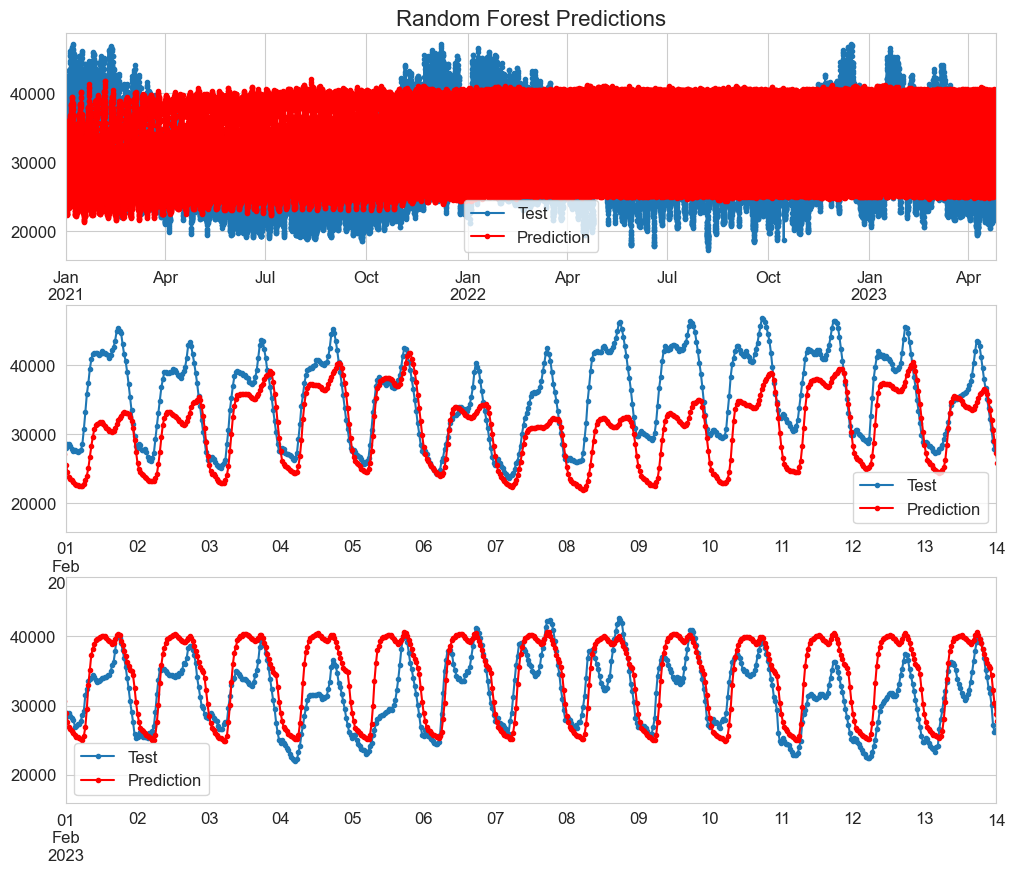

In [31]:
fig, (ax, bx, cx) = plt.subplots(3,1,figsize=(12, 10))

test.plot(ax=ax, marker='.', label='Test')
RF_pred2.plot(ax=ax, marker='.', label='Prediction', color='r')
ax.legend()
ax.set_title('Random Forest Predictions')
ax.set_xlabel('')

test.plot(ax=bx, marker='.', label='Test')
RF_pred2.plot(ax=bx, marker='.', label='Prediction', color='r')
bx.legend()
bx.set_xlabel('')
bx.set_xbound(lower=datetime.date(2021,2,1), upper=datetime.date(2021,2,14))

test.plot(ax=cx, marker='.', label='Test')
RF_pred2.plot(ax=cx, marker='.', label='Prediction', color='r')
cx.legend()
cx.set_xlabel('')
cx.set_xbound(lower=datetime.date(2023,2,1), upper=datetime.date(2023,2,14))

**Error**

In [32]:
RF_mse2  = mean_squared_error(y_true = test,y_pred = RF_pred2)
RF_mape2 = mean_absolute_percentage_error(y_true=test, y_pred=RF_pred2)

print('MAPE:', RF_mape2)
print('MSE: ', RF_mse2)

MAPE: 19.039458118657514
MSE:  44949987.36405498


#### Model 3: Forecasting with the previous month ??

#### Model 3: Daily data

In [33]:
steps2 = len(test2)

In [34]:
t1 = time.perf_counter()
RF3 = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123, n_estimators=10),
                lags = 365*2)

RF3.fit(y=train2) # fit the model
t2 = time.perf_counter()
RF_time3 = t2-t1

In [35]:
%%time
RF_pred3 = RF3.predict(steps=steps2) # predict
RF_pred3.head(5)

Wall time: 750 ms


2021-01-01    1587692.6
2021-01-02    1409683.3
2021-01-03    1421416.1
2021-01-04    1494260.6
2021-01-05    1572059.6
Freq: D, Name: pred, dtype: float64

Text(0.5, 0, '')

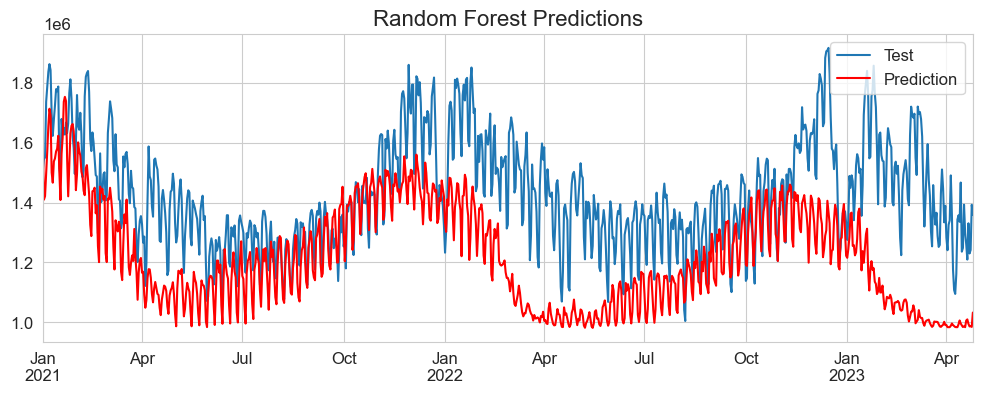

In [36]:
fig, ax = plt.subplots(figsize=(12, 4))

test2.plot(ax=ax, label='Test')
RF_pred3.plot(ax=ax, label='Prediction', color='r')
ax.legend()
ax.set_title('Random Forest Predictions')
ax.set_xlabel('')

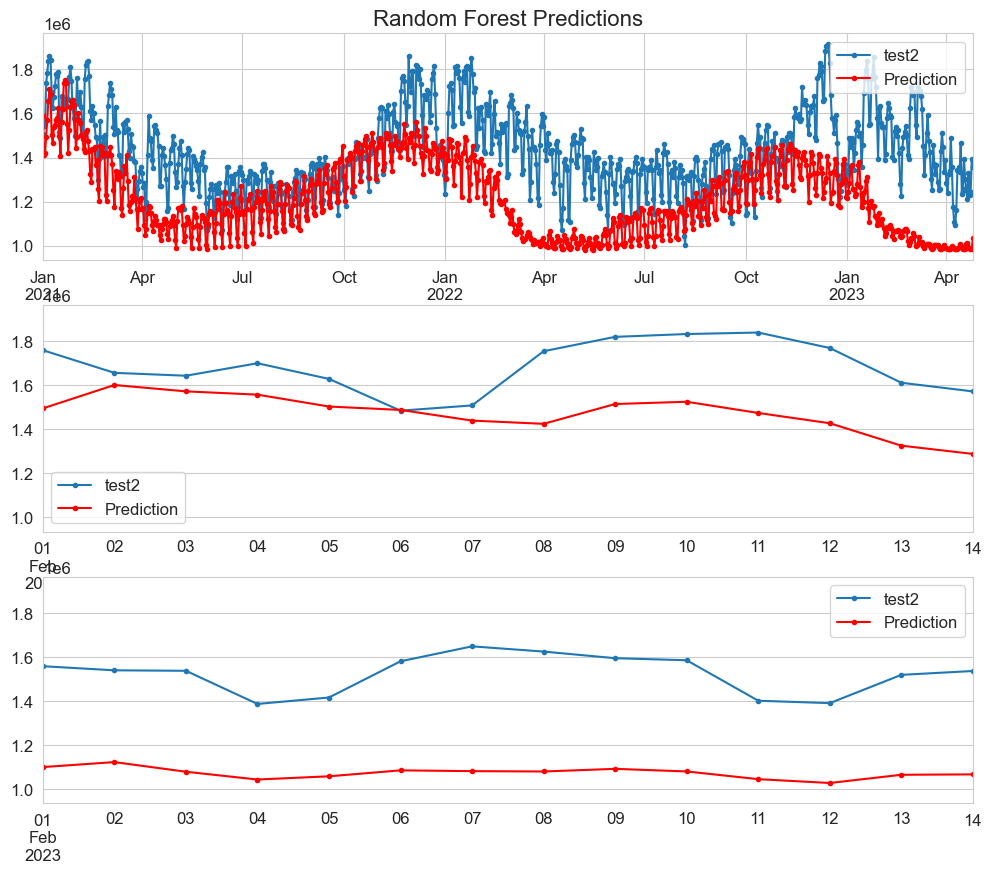

In [37]:
fig, (ax, bx, cx) = plt.subplots(3,1,figsize=(12, 10))

test2.plot(ax=ax, marker='.', label='test2')
RF_pred3.plot(ax=ax, marker='.', label='Prediction', color='r')
ax.legend()
ax.set_title('Random Forest Predictions')
ax.set_xlabel('')

test2.plot(ax=bx, marker='.', label='test2')
RF_pred3.plot(ax=bx, marker='.', label='Prediction', color='r')
bx.legend()
bx.set_xlabel('')
bx.set_xbound(lower=datetime.date(2021,2,1), upper=datetime.date(2021,2,14))

test2.plot(ax=cx, marker='.', label='test2')
RF_pred3.plot(ax=cx, marker='.', label='Prediction', color='r')
cx.legend()
cx.set_xlabel('')
cx.set_xbound(lower=datetime.date(2023,2,1), upper=datetime.date(2023,2,14))

**Error**

In [38]:
RF_mse3  = mean_squared_error(y_true = test2,y_pred = RF_pred3)
RF_mape3 = mean_absolute_percentage_error(y_true=test2, y_pred=RF_pred3)

print('MAPE:', RF_mape3)
print('MSE: ', RF_mse3)

MAPE: 14.877881682439792
MSE:  71039738832.86119


In [39]:
# predicciones = RF3.predict_interval(
#                     steps    = steps2,
#                     interval = [1, 99],
#                     n_boot   = 500
#                )

In [40]:
# fig, ax = plt.subplots(figsize=(7, 2.5))
# test2.plot(ax=ax, label='test')
# predicciones['pred'].plot(ax=ax, label='predicciones')
# ax.fill_between(
#     predicciones.index,
#     predicciones['lower_bound'],
#     predicciones['upper_bound'],
#     color = 'red',
#     alpha = 0.2
# )
# ax.legend();

### XGBoost

#### Model 1: Forecasting with the previous day

In [41]:
t1 = time.perf_counter()
XGB1 = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123, max_depth=5),
                lags = 48)

XGB1.fit(y=train) # fit the model
t2 = time.perf_counter()
XGB_time1 = t2-t1

In [42]:
%%time
XGB_pred1 = XGB1.predict(steps=steps) # predict

Wall time: 57.8 s


Text(0.5, 0, '')

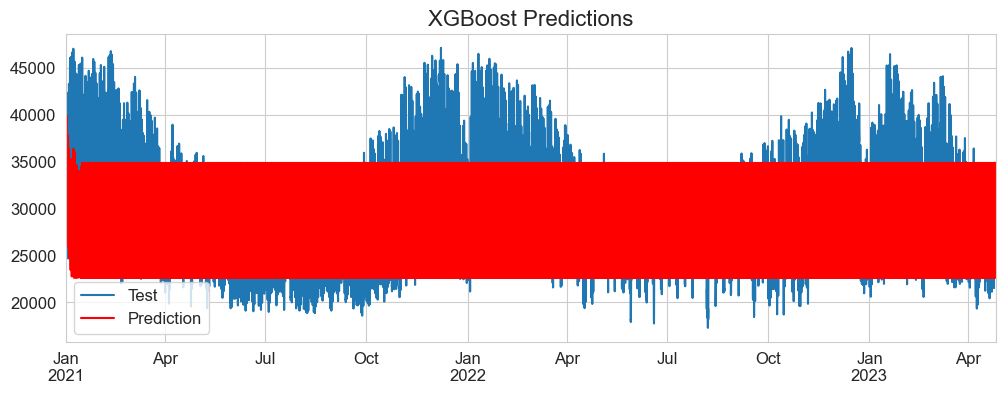

In [43]:
fig, ax = plt.subplots(figsize=(12, 4))
test.plot(ax=ax, label='Test')
XGB_pred1.plot(ax=ax, label='Prediction', color='r')
ax.legend()
ax.set_title('XGBoost Predictions')
ax.set_xlabel('')

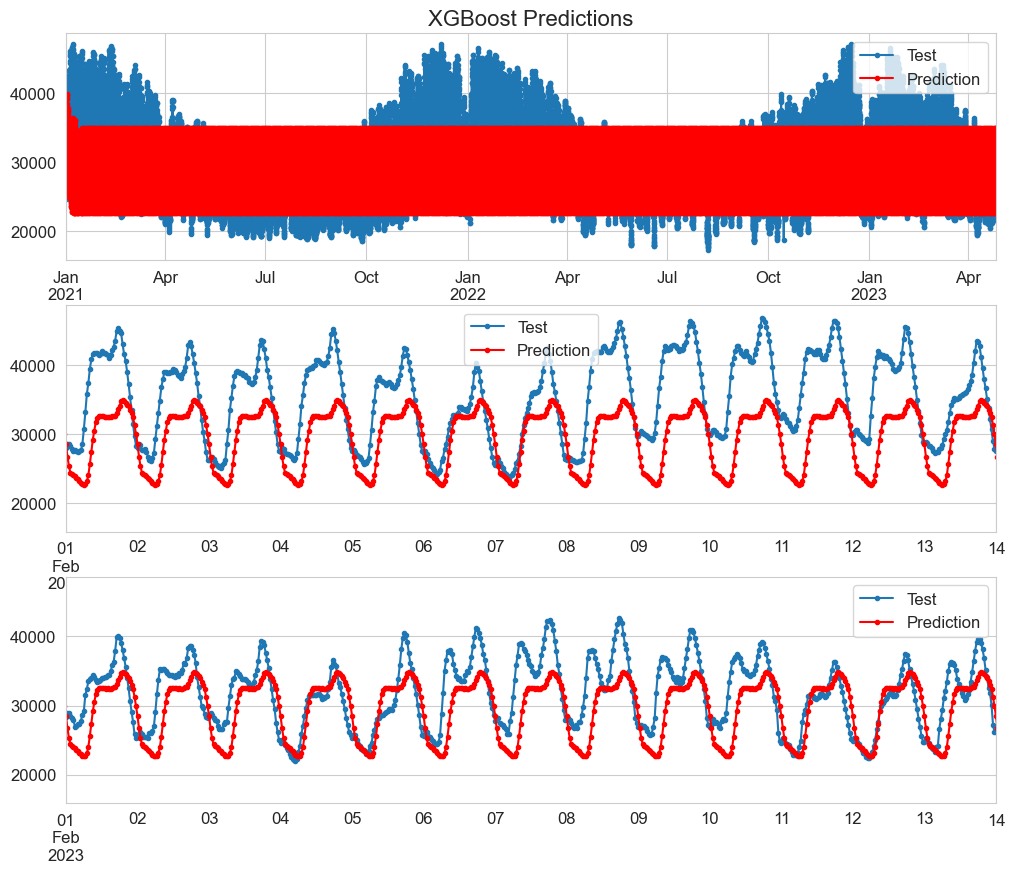

In [44]:
fig, (ax, bx, cx) = plt.subplots(3,1,figsize=(12, 10))

test.plot(ax=ax, marker='.', label='Test')
XGB_pred1.plot(ax=ax, marker='.', label='Prediction', color='r')
ax.legend()
ax.set_title('XGBoost Predictions')
ax.set_xlabel('')

test.plot(ax=bx, marker='.', label='Test')
XGB_pred1.plot(ax=bx, marker='.', label='Prediction', color='r')
bx.legend()
bx.set_xlabel('')
bx.set_xbound(lower=datetime.date(2021,2,1), upper=datetime.date(2021,2,14))

test.plot(ax=cx, marker='.', label='Test')
XGB_pred1.plot(ax=cx, marker='.', label='Prediction', color='r')
cx.legend()
cx.set_xlabel('')
cx.set_xbound(lower=datetime.date(2023,2,1), upper=datetime.date(2023,2,14))

**Error**

In [45]:
XGB_mse1  = mean_squared_error(y_true = test,y_pred = XGB_pred1)
XGB_mape1 = mean_absolute_percentage_error(y_true=test, y_pred=XGB_pred1)

print('MAPE:', XGB_mape1)
print('MSE: ', XGB_mse1)

MAPE: 13.128790020560485
MSE:  24235647.84642631


#### Model 2: Forecasting with the previous week

In [46]:
t1 = time.perf_counter()
XGB2 = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123, n_estimators=10),
                lags = 48*7)

XGB2.fit(y=train) # fit the model
t2 = time.perf_counter()
XGB_time2 = t2-t1

In [47]:
%%time
XGB_pred2 = XGB2.predict(steps=steps) # predict

Wall time: 31.3 s


Text(0.5, 0, '')

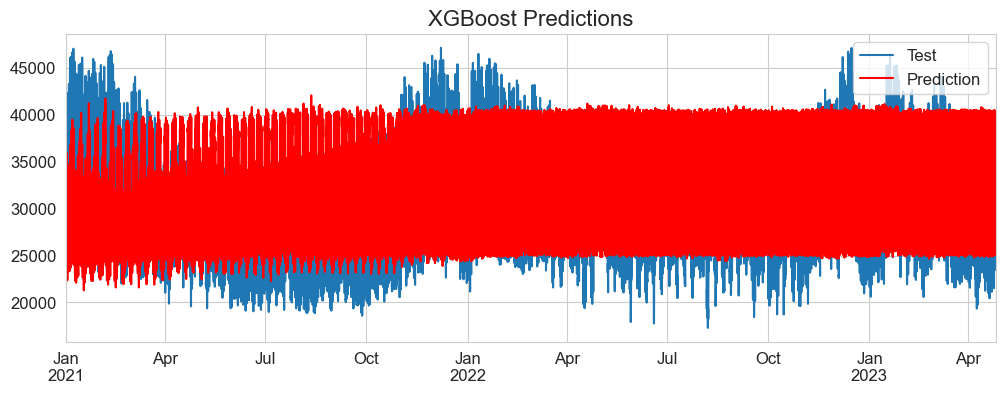

In [48]:
fig, ax = plt.subplots(figsize=(12, 4))
test.plot(ax=ax, label='Test')
XGB_pred2.plot(ax=ax, label='Prediction', color='r')
ax.legend()
ax.set_title('XGBoost Predictions')
ax.set_xlabel('')

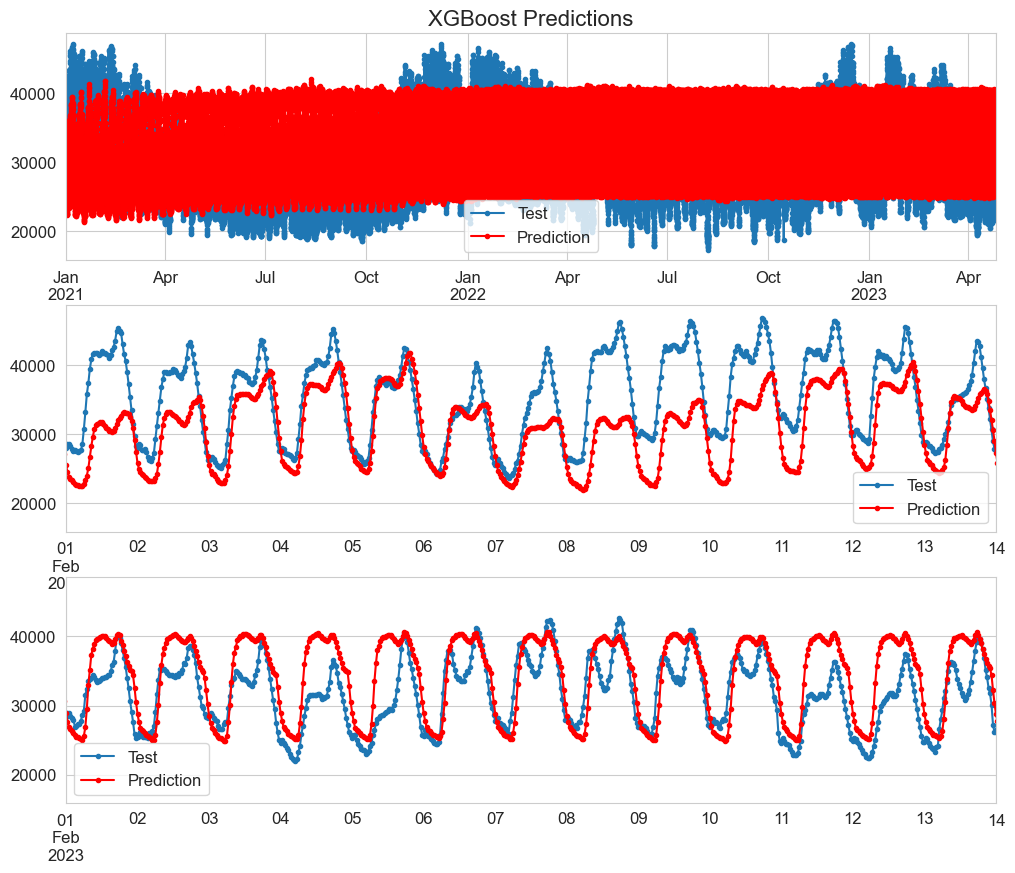

In [49]:
fig, (ax, bx, cx) = plt.subplots(3,1,figsize=(12, 10))

test.plot(ax=ax, marker='.', label='Test')
XGB_pred2.plot(ax=ax, marker='.', label='Prediction', color='r')
ax.legend()
ax.set_title('XGBoost Predictions')
ax.set_xlabel('')

test.plot(ax=bx, marker='.', label='Test')
XGB_pred2.plot(ax=bx, marker='.', label='Prediction', color='r')
bx.legend()
bx.set_xlabel('')
bx.set_xbound(lower=datetime.date(2021,2,1), upper=datetime.date(2021,2,14))

test.plot(ax=cx, marker='.', label='Test')
XGB_pred2.plot(ax=cx, marker='.', label='Prediction', color='r')
cx.legend()
cx.set_xlabel('')
cx.set_xbound(lower=datetime.date(2023,2,1), upper=datetime.date(2023,2,14))

**Error**

In [50]:
XGB_mse2  = mean_squared_error(y_true = test,y_pred = XGB_pred2)
XGB_mape2 = mean_absolute_percentage_error(y_true=test, y_pred=XGB_pred2)

print('MAPE:', XGB_mape2)
print('MSE: ', XGB_mse2)

MAPE: 19.039458118657514
MSE:  44949987.36405498


#### Model 3: Forecasting with the previous month

In [51]:
t1 = time.perf_counter()
XGB3 = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123, n_estimators=10),
                lags = 48*30)

XGB3.fit(y=train) # fit the model
t2 = time.perf_counter()
XGB_time3 = t2-t1

In [52]:
%%time
XGB_pred3 = XGB3.predict(steps=steps) # predict

Wall time: 31.7 s


Text(0.5, 0, '')

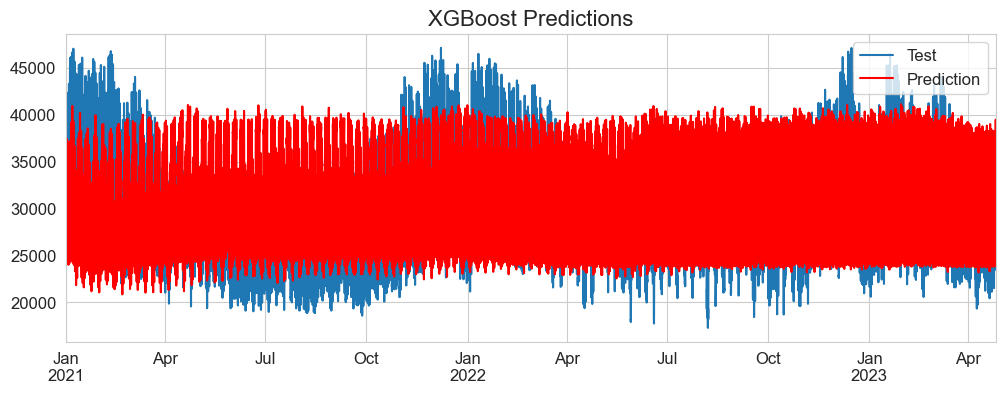

In [53]:
fig, ax = plt.subplots(figsize=(12, 4))
test.plot(ax=ax, label='Test')
XGB_pred3.plot(ax=ax, label='Prediction', color='r')
ax.legend()
ax.set_title('XGBoost Predictions')
ax.set_xlabel('')

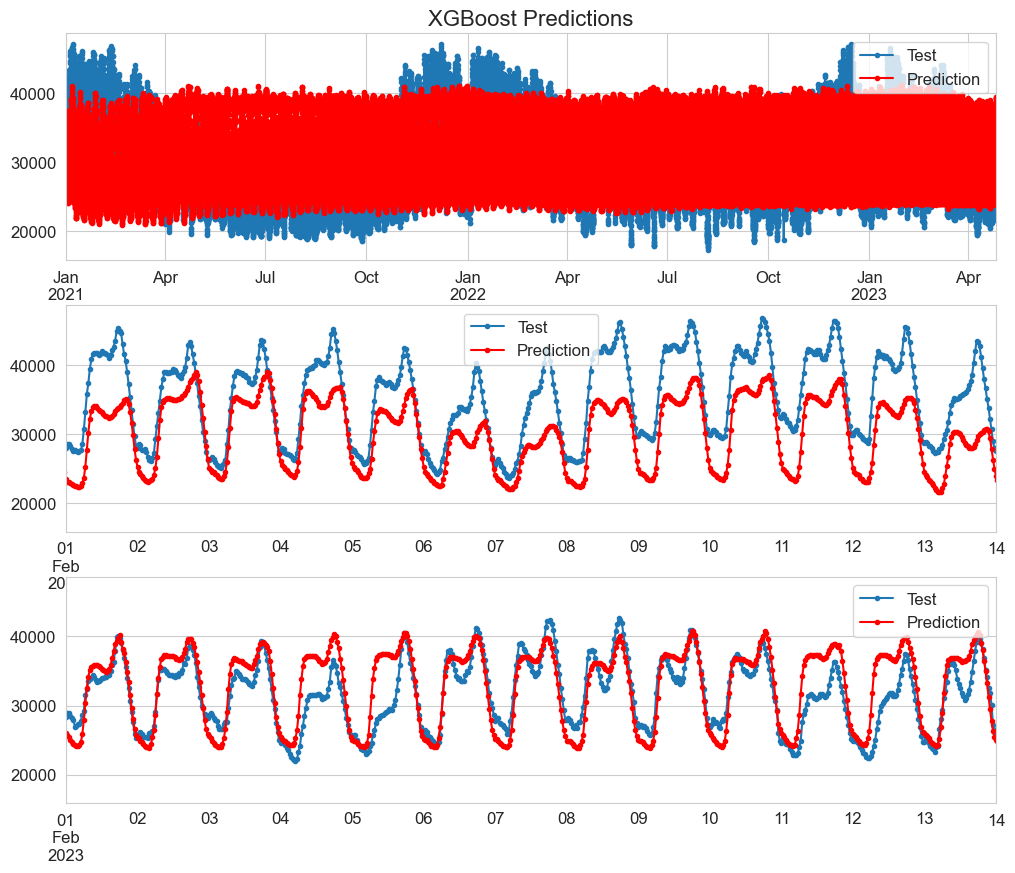

In [125]:
fig, (ax, bx, cx) = plt.subplots(3,1,figsize=(12, 10))

test.plot(ax=ax, marker='.', label='Test')
XGB_pred3.plot(ax=ax, marker='.', label='Prediction', color='r')
ax.legend()
ax.set_title('XGBoost Predictions')
ax.set_xlabel('')

test.plot(ax=bx, marker='.', label='Test')
XGB_pred3.plot(ax=bx, marker='.', label='Prediction', color='r')
bx.legend()
bx.set_xlabel('')
bx.set_xbound(lower=datetime.date(2021,2,1), upper=datetime.date(2021,2,14))

test.plot(ax=cx, marker='.', label='Test')
XGB_pred3.plot(ax=cx, marker='.', label='Prediction', color='r')
cx.legend()
cx.set_xlabel('')
cx.set_xbound(lower=datetime.date(2023,2,1), upper=datetime.date(2023,2,14))

plt.savefig("../graphs/XGBoost.png")

**Error**

In [55]:
XGB_mse3  = mean_squared_error(y_true = test,y_pred = XGB_pred3)
XGB_mape3 = mean_absolute_percentage_error(y_true=test, y_pred=XGB_pred3)

print('MAPE:', XGB_mape3)
print('MSE: ', XGB_mse3)

MAPE: 14.975039694289322
MSE:  29374728.671074945


#### Model 4: Tunning

In [65]:
%%time
t1 = time.perf_counter()
XGB4 = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123, learning_rate=0.1),
                lags = 48*7)

XGB4.fit(y=train) # fit the model
t2 = time.perf_counter()
XGB_time4 = t2-t1

Wall time: 3min 16s


In [66]:
%%time
XGB_pred4 = XGB4.predict(steps=steps) # predict

Wall time: 58.5 s


Text(0.5, 0, '')

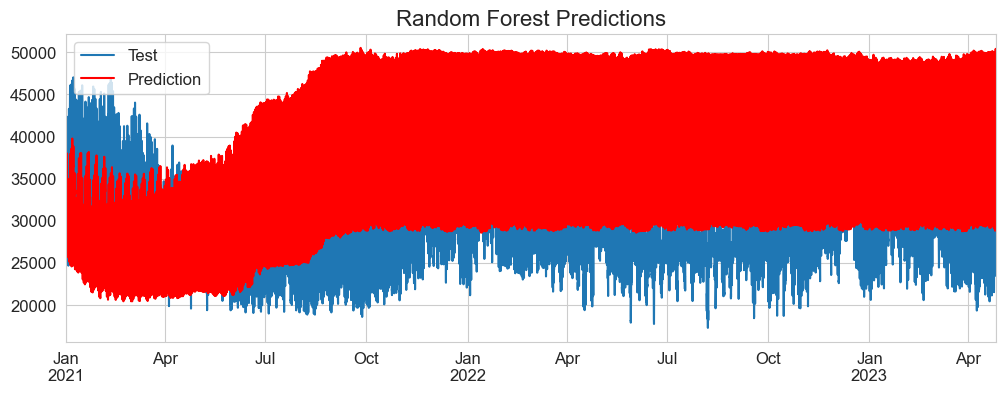

In [67]:
fig, ax = plt.subplots(figsize=(12, 4))
test.plot(ax=ax, label='Test')
XGB_pred4.plot(ax=ax, label='Prediction', color='r')
ax.legend()
ax.set_title('Random Forest Predictions')
ax.set_xlabel('')

In [82]:
%%time
t1 = time.perf_counter()
XGB6 = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123, learning_rate=0.2),
                lags = 48*30)

XGB6.fit(y=train) # fit the model
t2 = time.perf_counter()
XGB_time6 = t2-t1

Wall time: 26min 43s


In [83]:
%%time
XGB_pred6 = XGB6.predict(steps=steps) # predict

Wall time: 1min 3s


Text(0.5, 0, '')

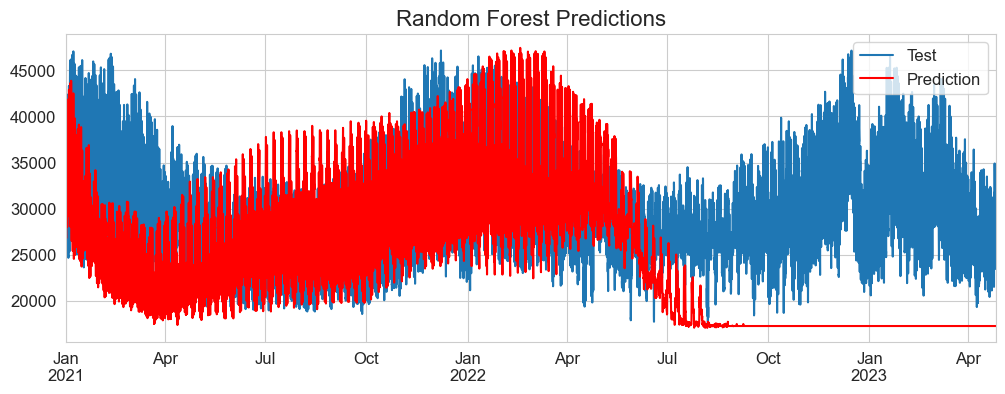

In [84]:
fig, ax = plt.subplots(figsize=(12, 4))
test.plot(ax=ax, label='Test')
XGB_pred6.plot(ax=ax, label='Prediction', color='r')
ax.legend()
ax.set_title('Random Forest Predictions')
ax.set_xlabel('')

In [103]:
%%time
t1 = time.perf_counter()
XGB7 = ForecasterAutoreg(
                regressor = XGBRegressor(random_state=123, learning_rate=0.25),
                lags = 48*30)

XGB7.fit(y=train) # fit the model
t2 = time.perf_counter()
XGB_time3 = t2-t1

Wall time: 14min 49s


In [104]:
%%time
XGB_pred7 = XGB7.predict(steps=steps) # predict

Wall time: 1min 43s


Text(0.5, 0, '')

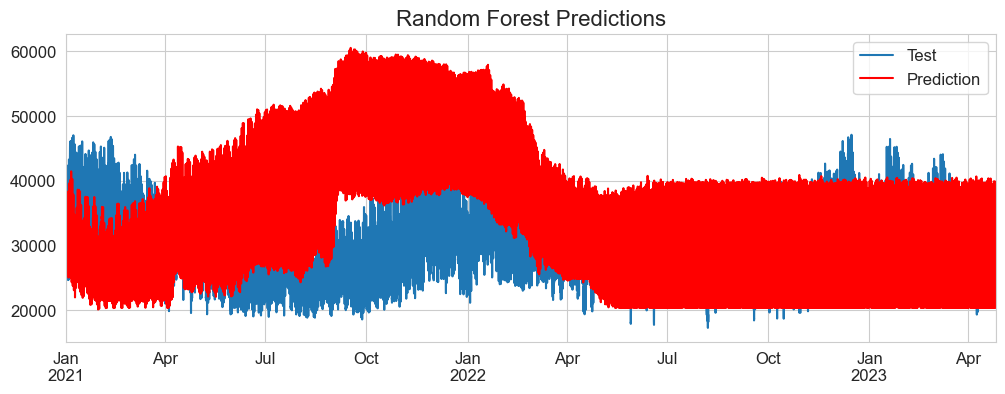

In [105]:
fig, ax = plt.subplots(figsize=(12, 4))
test.plot(ax=ax, label='Test')
XGB_pred7.plot(ax=ax, label='Prediction', color='r')
ax.legend()
ax.set_title('Random Forest Predictions')
ax.set_xlabel('')

In [114]:
XGB_mse4  = mean_squared_error(y_true = test,y_pred = XGB_pred4)
XGB_mape4 = mean_absolute_percentage_error(y_true=test, y_pred=XGB_pred4)

print('MAPE:', XGB_mape4)
print('MSE: ', XGB_mse4)

MAPE: 28.174376607223717
MSE:  90180445.10429119


In [115]:
XGB_mse6  = mean_squared_error(y_true = test,y_pred = XGB_pred6)
XGB_mape6 = mean_absolute_percentage_error(y_true=test, y_pred=XGB_pred6)

print('MAPE:', XGB_mape6)
print('MSE: ', XGB_mse6)

MAPE: 25.065947356121754
MSE:  91052095.98077756


In [116]:
XGB_mse7  = mean_squared_error(y_true = test,y_pred = XGB_pred7)
XGB_mape7 = mean_absolute_percentage_error(y_true=test, y_pred=XGB_pred7)

print('MAPE:', XGB_mape7)
print('MSE: ', XGB_mse7)

MAPE: 35.120758966605685
MSE:  145810770.47574413


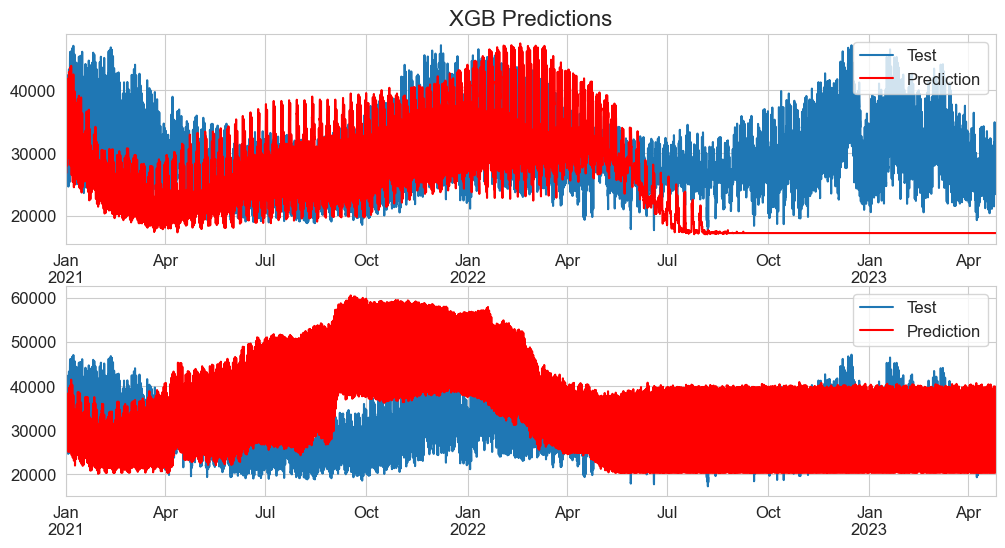

In [134]:
fig, (ax, bx) = plt.subplots(2,1,figsize=(12, 6))
test.plot(ax=ax, label='Test')
XGB_pred6.plot(ax=ax, label='Prediction', color='r')
ax.legend()
ax.set_title('XGB Predictions')
ax.set_xlabel('')

test.plot(ax=bx, label='Test')
XGB_pred7.plot(ax=bx, label='Prediction', color='r')
bx.legend()
bx.set_xlabel('')
plt.savefig("../graphs/XGBoost_adjust.png")

**Results**

In [119]:
x = ['RF1', 'RF2', 'XGB1', 'XGB2', 'XGB3', 'XGB4', 'XGB6', 'XGB7']
y1 = [RF_mape1, RF_mape2, XGB_mape1, XGB_mape2, XGB_mape3, XGB_mape4, XGB_mape6, XGB_mape7]
y2 = [RF_mse1, RF_mse2, XGB_mse1, XGB_mse2, XGB_mse3, XGB_mse4, XGB_mse6, XGB_mse7]
y3 = [RF_time1, RF_time2, XGB_time1, XGB_time2, XGB_time3, XGB_time4, XGB_time6, XGB_time7]

In [106]:
y3

[96.2381584, 635.3491981, 17.304973000000018, 623.7853124000001, 2821.5810387]

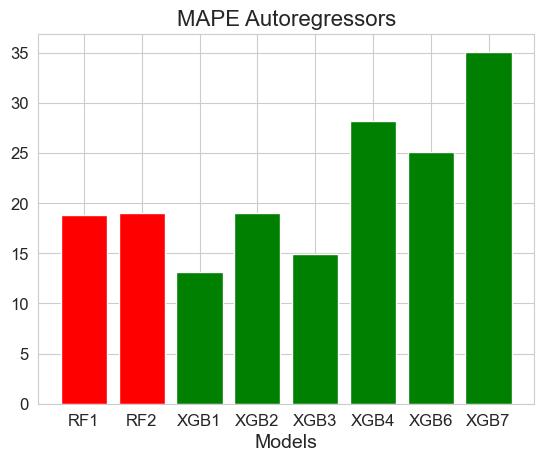

In [121]:
plt.bar(x, y1, color=['red','red', 'green', 'green', 'green', 'green', 'green', 'green'])
plt.xlabel('Models')
plt.ylabel('')
plt.title('MAPE Autoregressors')
plt.show()

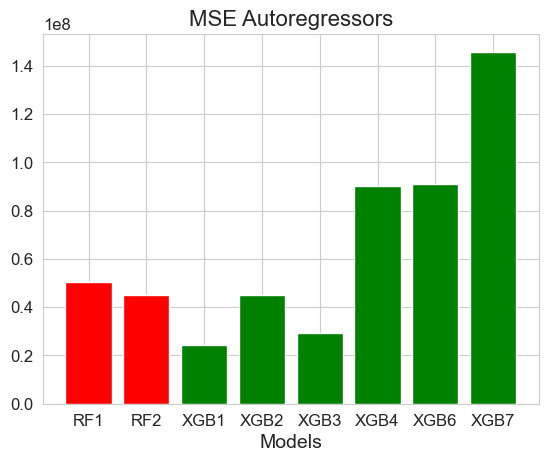

In [122]:
plt.bar(x, y2, color=['red','red', 'green', 'green', 'green', 'green', 'green', 'green'])
plt.xlabel('Models')
plt.ylabel('')
plt.title('MSE Autoregressors')
plt.show()

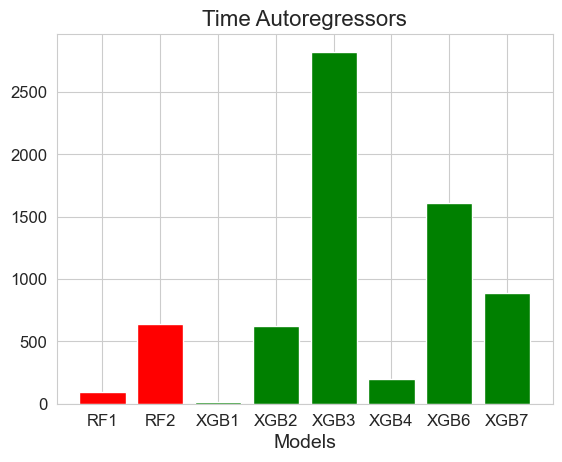

In [123]:
plt.bar(x, y3, color=['red','red', 'green', 'green', 'green', 'green', 'green', 'green'])
plt.xlabel('Models')
plt.ylabel('')
plt.title('Time Autoregressors')
plt.show()

In [129]:
df = pd.DataFrame([y1,y2, y3], columns=x, index=['MAPE', 'MSE', 'Time'])
df = df.T
df

,MAPE,MSE,Time
RF1,18.820462,5.023864e+07,96.238158
RF2,19.039458,4.494999e+07,635.349198
XGB1,13.128790,2.423565e+07,17.304973
XGB2,19.039458,4.494999e+07,623.785312
XGB3,14.975040,2.937473e+07,2821.581039
XGB4,28.174377,9.018045e+07,196.213466
XGB6,25.065947,9.105210e+07,1608.645877
XGB7,35.120759,1.458108e+08,889.468546


In [62]:
joblib.dump(RF1, project_path.joinpath('data/models/autoreg/RF1.pkl'))
joblib.dump(RF2, project_path.joinpath('data/models/autoreg/RF2.pkl'))
joblib.dump(XGB1, project_path.joinpath('data/models/autoreg/XGB1.pkl'))
joblib.dump(XGB2, project_path.joinpath('data/models/autoreg/XGB2.pkl'))
joblib.dump(XGB3, project_path.joinpath('data/models/autoreg/XGB3.pkl'))

['C:\\Users\\mpena\\OneDrive\\Escritorio\\TFG\\CODIGO\\TFG\\data\\models\\autoreg\\XGB3.pkl']

In [113]:
joblib.dump(XGB4, project_path.joinpath('data/models/autoreg/XGB4.pkl'))
joblib.dump(XGB6, project_path.joinpath('data/models/autoreg/XGB6.pkl'))
joblib.dump(XGB7, project_path.joinpath('data/models/autoreg/XGB7.pkl'))

['C:\\Users\\mpena\\OneDrive\\Escritorio\\TFG\\CODIGO\\TFG\\data\\models\\autoreg\\XGB7.pkl']

In [132]:
df.to_csv('../data/results/autoreg.csv')

In [149]:
result = XGB3.get_feature_importances()
result

,feature,importance
0,lag_1,0.981439
1,lag_2,0.001543
2,lag_3,0.004002
3,lag_4,0.000562
4,lag_5,0.000064
...,...,...
1435,lag_1436,0.000002
1436,lag_1437,0.000001
1437,lag_1438,0.000002
1438,lag_1439,0.000002


In [151]:
result.sort_values('importance', ascending=False)

,feature,importance
0,lag_1,9.814392e-01
2,lag_3,4.002060e-03
332,lag_333,2.433653e-03
333,lag_334,2.240072e-03
1,lag_2,1.543412e-03
...,...,...
557,lag_558,7.017989e-07
1131,lag_1132,6.926963e-07
797,lag_798,6.722746e-07
938,lag_939,6.691278e-07


In [153]:
result2 = XGB7.get_feature_importances()
result2.sort_values('importance', ascending=False)

,feature,importance
0,lag_1,0.700984
333,lag_334,0.015709
668,lag_669,0.013187
2,lag_3,0.010674
332,lag_333,0.009673
...,...,...
918,lag_919,0.000000
917,lag_918,0.000000
502,lag_503,0.000000
509,lag_510,0.000000


<BarContainer object of 10 artists>

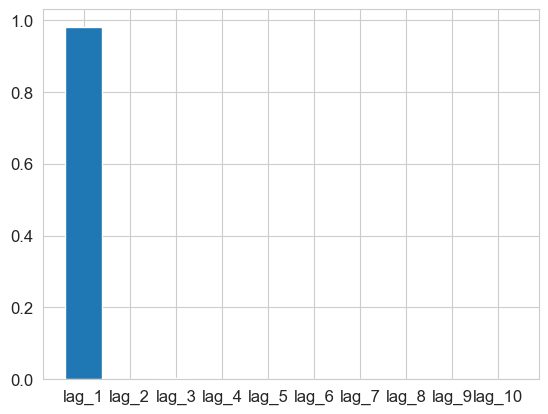

In [148]:
plt.bar(feature[:10], importance[:10])